# Chargement des données
* Import des librairies/modules nécessaires
* Décompression du dataset

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from IPython.display import FileLink
import seaborn as sns
from sklearn.metrics import confusion_matrix

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!tar xzf /kaggle/input/ships2021/ships2021.tgz
!ls /kaggle/working/train

/kaggle/input/ships-custom-test-data-set/ships_test/vsmallfish/1.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/vsmallfish/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/vsmallfish/2.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/coastguard/1.png
/kaggle/input/ships-custom-test-data-set/ships_test/coastguard/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/coastguard/2.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/1.png
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/2.png
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/4.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/1.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/4.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/2.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/ferry/1.jpg
/kaggl

# Génération des données d'entrainement

L'`ImageDataGenerator` de keras nous permet de faire deux choses à la fois: 
1. Split notre dataset original par batch en jeu d'entraînement et de validation (12%). 
2. Augmenter la taille de notre dataset

L'augmentation en temps réel du dataset, apporte une solution au problème d'*overfitting* en augmentant la diversité des données disponibles pour l'entraînement des modèles, sans collecter de nouvelles données. Pour ce faire notre générateur appliquera certaines opérations de transformations d'image : 
- Déplacement horizontal et vertical ([-10%, 10%])
- Zoom ([-10%, 10%])
- Symétrie horizontale

Dans le cadre de cette compétition, nous avons en plus, appliqué une augmentation par une opération de rotation aléatoire comprise entre [-20%, 20%]. 

L'augmentation va ainsi permettre d'améliorer les performances du modèle en réduisant le **biais** des données et améliorer la **généralisation** du modèle.

Enfin, nous savons que les images du dataset donné n'ont pas une taille uniforme, certaines sont en mode portrait alors que d'autres en paysage. C'est problématique puisque le générateur utilisé va devoir étirer ou rétrécir les images pour qu'elle soient toutes aux mêmes dimensions. Afin de remédier à cela, nous avons décidé pour cette compétition d'uniformiser le tout à (128, 128).

In [9]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=20,
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        validation_split=0.12,
        fill_mode="nearest",
)

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(128, 128),
        batch_size=batch_size,
        subset="training")

validation_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(128, 128),
        batch_size=batch_size,
        subset="validation")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/kaggle/input/ships-custom-test-data-set/ships_test/',
        target_size=(128, 128),
        batch_size=batch_size)

Found 43582 images belonging to 13 classes.
Found 5935 images belonging to 13 classes.
Found 48 images belonging to 13 classes.


# Définition du modèle

EfficientNet est un CNN très performant, qui s'appuie sur l'AutoML et l'échelonnement composé (*compound scaling*) pour obtenir des performances supérieures sans compromettre l'efficacité en termes d'utilisation des ressources.

L'échelonnement composé consiste à échelonner (augmenter ou diminuer = *scaling*) de manière homogène les 3 dimensions d'un modèle (largeur, profondeur, résolution). 

<img src="https://miro.medium.com/max/602/1*Bmcle6eoXTEWM6BdVu43Jw.png" width=50% height=50%>

La librairie AutoML, a permis de développer un réseau compact de base: EfficientNet-B0. Ce dernier peut être drastiquement amélioré via le compound scaling, pour obtenir les variantes de différentes tailles: EfficientNetB1 à B7.

<img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" width=50% height=50%>

EfficientNet-B7 est le modèle qui possède la meilleure TOP-1 précision (*accuracy*), cette performance à néanmoins un coût de recherche liée aux 68 millions de paramètres du modèle.

In [10]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

model = Sequential([efn.EfficientNetB7(input_shape=(128, 128, 3), weights='noisy-student', include_top=False),
                             GlobalAveragePooling2D(),
                             Dense(128, activation = "relu"),
                             Dropout(0.2),
                             Dense(64, activation = "relu"),
                             BatchNormalization(),
                             Dense(13, activation='softmax')])

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

#### Rechargement du meilleur modèle


* Si un modèle ou des poids pour ce modèle on déjà été calculés, nous pouvons les charger afin d'éviter un nouvel entrainement complet.
* Dans le cas où le dernier modèle entraîné est moins bon que celui enregistré lors du dernier checkpoint, alors on préferera recharger le checkpoint.

In [11]:
model_save_path = "model_save.h5"
weights_save_path = "weights_save.h5"

if os.path.isfile(model_save_path):
    model = load_model(model_save_path)
    print("Model saved loaded")
    
if os.path.isfile(weights_save_path):
    model.load_weights(weights_save_path)
    print("Weights saved load on model")

# if the last model checkpoint is better than the final model then uncomment 
# model = load_model("./best_model.hdf5")

In [12]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  7


## Procédure d'entrainement du modèle

Deux callbacks utilisés:
- `EarlyStopping` afin d'éviter le sur-entraînement, dans le cas où le résultat sur le jeu de validation stagne ou diminue (pendant un certains nombre d'epochs prédéfinis), on arrête automatiquement l'entrainement.
- `ModelCheckpoint` qui va sauvegarder après chaque epoch le modèle, **si** ce dernier est meilleur sur le jeu de validation que celui précédemment enregistré.

In [13]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_loss', verbose=1,
                                save_best_only=True, mode='auto', period=1)

In [15]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=8, epochs=8, callbacks=[earlystopping, checkpoint])

Epoch 1/8
1362/1362 [==============================] - 626s 432ms/step - loss: 2.3916 - accuracy: 0.2092 - val_loss: 1.0368 - val_accuracy: 0.6148

Epoch 00001: val_loss improved from inf to 1.03683, saving model to best_model.hdf5
Epoch 2/8
1362/1362 [==============================] - 585s 428ms/step - loss: 0.9209 - accuracy: 0.6853 - val_loss: 0.6137 - val_accuracy: 0.7818

Epoch 00002: val_loss improved from 1.03683 to 0.61370, saving model to best_model.hdf5
Epoch 3/8
1362/1362 [==============================] - 583s 427ms/step - loss: 0.6406 - accuracy: 0.7781 - val_loss: 0.5127 - val_accuracy: 0.8147

Epoch 00003: val_loss improved from 0.61370 to 0.51269, saving model to best_model.hdf5
Epoch 4/8
1362/1362 [==============================] - 585s 428ms/step - loss: 0.5305 - accuracy: 0.8169 - val_loss: 0.5313 - val_accuracy: 0.8185

Epoch 00004: val_loss did not improve from 0.51269
Epoch 5/8
1362/1362 [==============================] - 579s 424ms/step - loss: 0.4663 - accuracy:

#### Sauvegarde du modèle et des poids associées

Ils seront rechargés lors d'une éxecution ultérieure.

In [16]:
model.save(model_save_path)
model.save_weights(weights_save_path)

## Résultats

Graphique représentant l'historique de la précision du modèle pendant son apprentissage. Deux courbes:
- Evolution de la précision sur le jeu d'entrainement versus jeu de validation

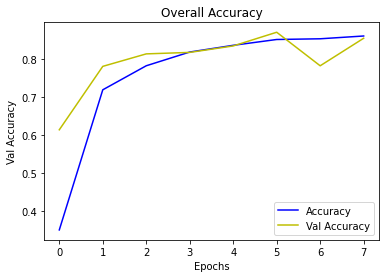

In [17]:
plt.plot(history.history['accuracy'], color='b', label="Accuracy")
plt.plot(history.history['val_accuracy'], color='y', label='Val Accuracy')
plt.title("Overall Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()

### Matrice de confusion sur le set de validation

On affiche une matrice confusion des résultats obtenus sur les images du 1er batch (32 images)

True label (category) values:  [10  1  5 12  5 11  6  1  7  8  5  9  1 10  1 10  5  6  6 10  6  3  5  2
  7  9  5  1  5  2 12 12]
Predicted label values:  [10  1  5 11  5 11  6  1  7  8  5  9  1 10  1 10  5  6  6 10  6  3  5  9
  1 12  5  1  5  2  9 12]


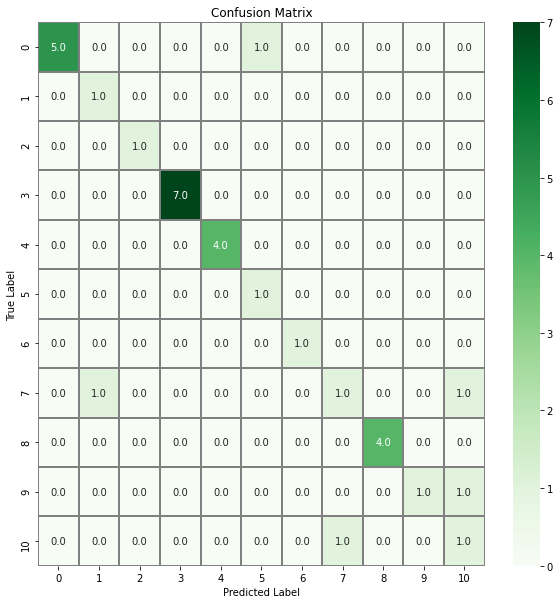

In [18]:
def compute_confusion(x, y_true):
    # Normalize Data
    max_value = float(x.max())
    x = x.astype('float32') / max_value
    
    """
    model.predict(x) prend un batch de 32 images normalisées 
    predict renvoie pour chaque image un array de 13 probabilités
    on récupère la probabilité maximale (=classe la plus probable selon la prédiction faite par le modèle)
    """
    res = model.predict(x).argmax(axis=1)
    
    # y_true est une matrice 32 * 13 tout comme res
    # sauf qu'ici les probabilités sont certaines pour chaque image [0, .., 1, ..]
    y_true = np.argmax(y_true, axis=1) 

    print("True label (category) values: ", res)
    print("Predicted label values: ", y_true)

    confusion_mtx = confusion_matrix(y_true, res) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

(x, y_true) = validation_generator.next() # returns 32 (batch size) test samples
compute_confusion(x, y_true)

### Test dataset evaluation

A partir d'un dataset fait maison, on cherche à évaluer l'efficacité du modèle sur ce dernier.

In [19]:
test_res = model.evaluate_generator(test_generator, workers=8, use_multiprocessing=True, verbose=1)
print("Test loss = {0} || Test accuracy {1}".format(test_res[0], test_res[1]))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


2/2 [==============================] - 4s 1s/step - loss: 1.0776 - accuracy: 0.7708
Test loss = 1.0776256322860718 || Test accuracy 0.7708333134651184


### Matrice de confusion sur le set de test

True label (category) values:  [ 5  4  4  8  6 10  5  2  6  5 10  6 11  9  7  6 11  6  9  4  7  1  9 11
  7  1  6 12  2  5  5  5]
Predicted label values:  [ 5  4  4  8  6 10  3  2  2  3 10  8 11  9  7  6 11  6  9  4  7  1 12 11
  7  1  6  0  2  5  5  3]


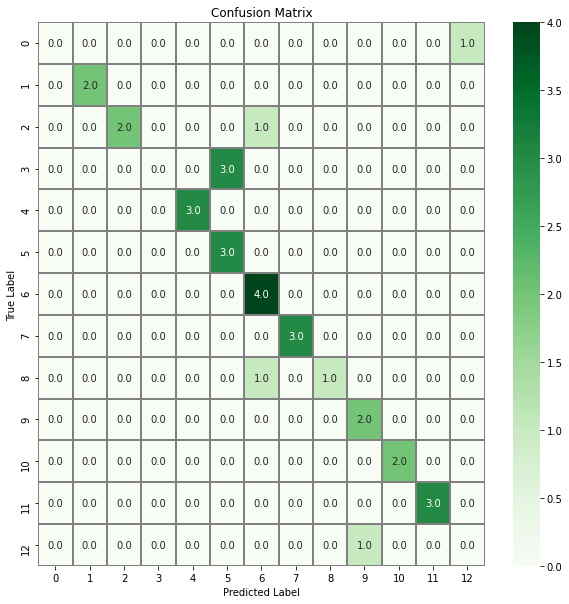

In [20]:
(x, y_true) = test_generator.next() # returns batch size (32) test samples
compute_confusion(x, y_true)

### Test et création des résultats pour la compétition Kaggle

Les images doivent elles aussi être correctement redimensionnées pour pouvoir être acceptées par le modèle.

In [21]:
from skimage.transform import resize

X_test = np.load('/kaggle/working/test_rot.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

new_shape = (128, 128, 3)
X_test_resized = []
for e in X_test:
    X_test_resized.append(resize(e, new_shape))
X_test_resized = np.asarray(X_test_resized)

In [22]:
res = model.predict(X_test_resized).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [23]:
!head reco_nav.csv

Id,Category
0,9
1,9
2,2
3,0
4,9
5,1
6,0
7,1
8,12


In [24]:
os.chdir(r'/kaggle/working')
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv